# The Johnson-Lindenstrauss bound for embedding with random projections
- `Johnson-Lindenstrauss` 정리에 따르면 고차원 데이터 집합은 pair간의 거리를 제어하면서 저차원 유클리드 공간에 무작위로 투영

In [1]:
import sys
from time import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized, load_digits
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import (
    SparseRandomProjection,
    johnson_lindenstrauss_min_dim,
)

## Theoretical bounds

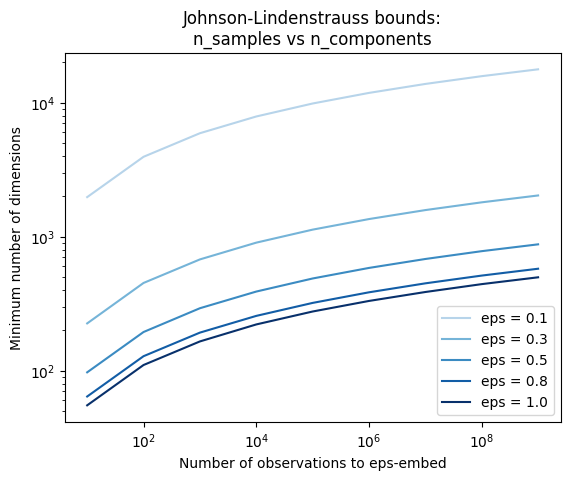

In [2]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend([f"eps = {eps:0.1f}" for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

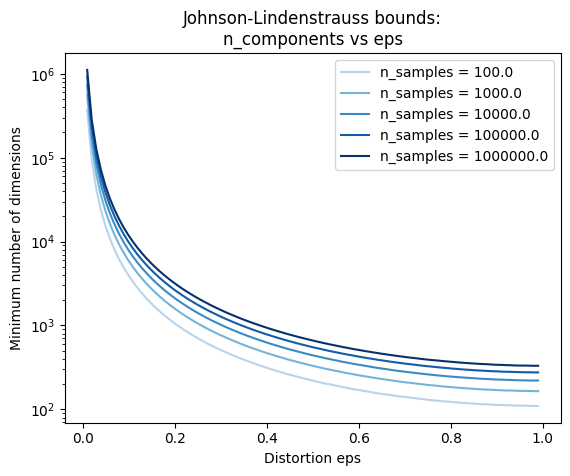

In [3]:
# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend([f"n_samples = {n}" for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

## Empirical validation

In [4]:
if "--use-digits-dataset" in sys.argv:
    data = load_digits().data[:300]
else:
    data = fetch_20newsgroups_vectorized().data[:300]

Embedding 300 samples with dim 130107 using various random projections
Projected 300 samples from 130107 to 300 in 0.261s
Random matrix with size: 1.298 MB
Mean distances rate: 1.01 (0.17)
Projected 300 samples from 130107 to 1000 in 0.871s
Random matrix with size: 4.328 MB
Mean distances rate: 1.00 (0.11)
Projected 300 samples from 130107 to 10000 in 8.877s
Random matrix with size: 43.295 MB
Mean distances rate: 1.03 (0.04)


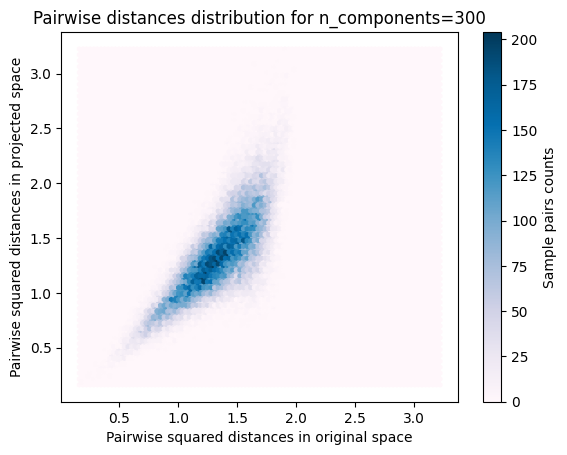

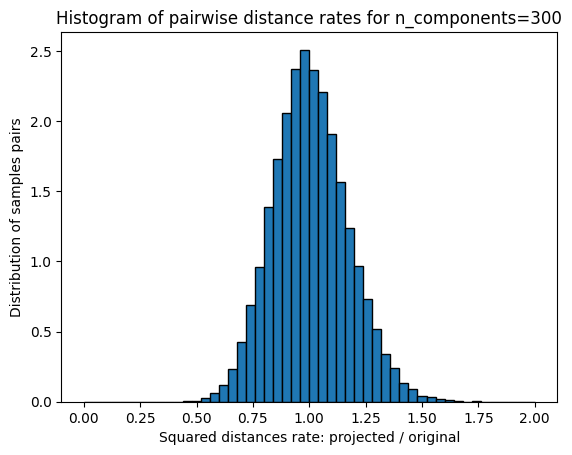

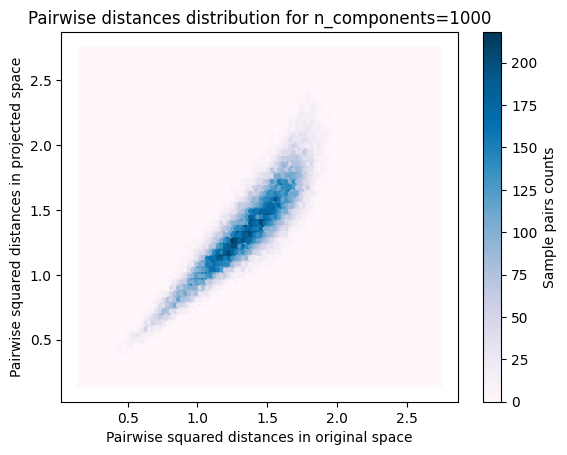

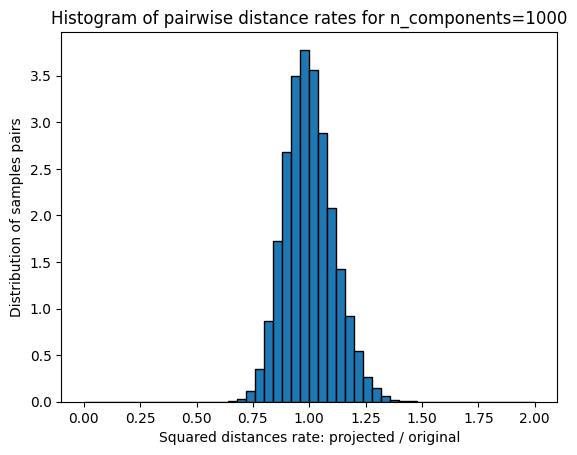

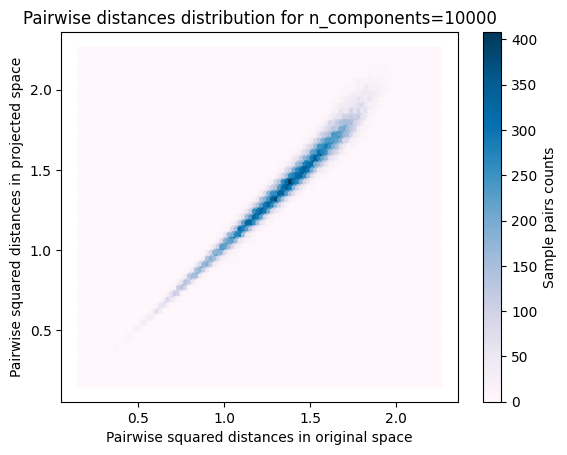

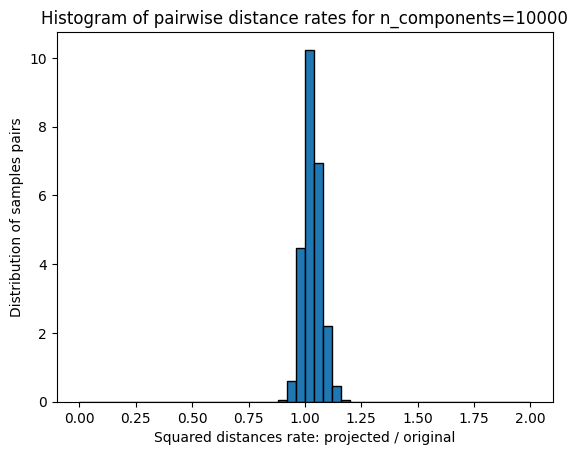

In [5]:
n_samples, n_features = data.shape
print(
    f"Embedding {n_samples} samples with dim {n_features} using various "
    "random projections"
)

n_components_range = np.array([300, 1_000, 10_000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print(
        f"Projected {n_samples} samples from {n_features} to {n_components} in "
        f"{time() - t0:0.3f}s"
    )
    if hasattr(rp, "components_"):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print(f"Random matrix with size: {n_bytes / 1e6:0.3f} MB")

    projected_dists = euclidean_distances(projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(
        dists,
        projected_dists,
        gridsize=100,
        cmap=plt.cm.PuBu,
        extent=[min_dist, max_dist, min_dist, max_dist],
    )
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" % n_components)
    cb = plt.colorbar()
    cb.set_label("Sample pairs counts")

    rates = projected_dists / dists
    print(f"Mean distances rate: {np.mean(rates):.2f} ({np.std(rates):.2f})")

    plt.figure()
    plt.hist(rates, bins=50, range=(0.0, 2.0), edgecolor="k", density=True)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" % n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()